# pandas 进阶修炼
<br>
本习题基于 `pandas` 版本 `1.1.3`，所有内容应当在 `Jupyter Notebook` 中执行以获得最佳效果。

不同版本之间写法可能会有少许不同，如若碰到此情况，你应该学会如何自行检索解决。

## 实战｜客户流失分析



<br>


**<font color = '#5172F0'><font size=3.5>必读👇👇👇</font>**
    
  
### 项目目的

深入了解用户画像及行为偏好，挖掘出影响用户流失的关键因素，并通过算法预测客户访问的转化结果，从而更好地完善产品设计、提升用户体验！

### 数据说明

此次数据是携程用户一周的访问数据，为保护客户隐私，已经将数据经过了脱敏，和实际商品的订单量、浏览量、转化率等有一些差距，不影响问题的可解性。

### 案例说明

分类信息app，通过数据挖掘分析影响用户流失的关键因素、深入了解用户行为偏好以此做出调整，提升客户留存率，增强客户黏性，并通过随机森林算法预测客户流失，通过特征创造使模型分数提高2个百分点。

### 项目内容
探索数据分布，缺失情况，针对性的进行缺失值填补，对于缺失较少的重要特征选择随机森林缺失填补法，使用3sigma、箱型图分析等对异常值进行处理，对分类型变量进行编码。

使用方差过滤、F检验过滤掉一部分特征，进行WOE分箱，对每个特征分箱结果进行可视化，分析每个特征分箱情况并以此分析 用户行为偏好，使用各个特征的IV值进一步筛选特征。

训练随机森林模型，模型调参、评估，输出模型，以此模型对用户流失进行预测，以便针对性地挽留用户。训练逻辑回归模型，通过其算法可解释性强的特点(特征系数)来对用户流失关键因素进行阐述。

本次案例分析仅展示数据清洗、特征工程及建模（随机森林分类模型）部分。完整案例可参见原文。

![p1.png](./picture/p1.png)



**<font color = '#5172F0'><font size=3.5>注意事项👇👇👇</font>**  
    
**注意1**：为了尽可能还原一次真实的数据分析项目，在食用本notebook时，可能会出现我们没有提示（解决方案）的报错，你应学会如何自行解决！

**注意2**：由于本案例后半部分涉及内容大多为机器学习相关，因此将不做习题使用，提供用于pandas操作练习的部分仅到20题为止！
   
**注意3**：为了尽可能让大家理解题意，我将保留每一题的运行结果，该结果仅供参考，只要完成题目要求，在样式和文字上无需保持一致！

## 初始化

<br>

该 `Notebook` 版本为**习题+答案版**


请执行下方单元格以初始化读取本节习题的答案

执行完毕后，你可以使用 `ans(1)` 来查看第 1 题的参考解答，其余习题类似。

注意：所有答案并非固定（唯一），我提供的答案仅供参考（并非推荐答案或者最优解）

In [74]:
import sys
sys.path.append('../document/')
from init import initialize, ans
res = initialize("../document/answer-s2.txt")

***************正在初始化***************
*************读取到配置文件*************
***************初始化成功***************


## 数据导入与探索性分析

![p1.png](picture\Snipaste_2022-08-27_10-54-43.png)

### 导入依赖包

执行以下代码来导入本项目使用到的相关库

**如果有任何导入相关的错误，大概率是因为你没有安装，根据报错提示使用 pip 安装即可。**

**导入库相关的问题不应在知识星球或者微信群进行提问！**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import datetime # 计时器
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
%matplotlib inline

#plt.rcParams['font.family'] = ['Arial Unicode MS']#显示中文,解决图中无法显示中文的问题
plt.rcParams['font.family'] = ['SimHei']
plt.rcParams['axes.unicode_minus']=False

### 1 -  导入数据

导入当前目录下 `userlostprob.txt`

In [2]:
data = pd.read_table('./userlostprob.txt')

### 2 - 数据查看

查看数据前几行

In [7]:
data.head()

,label,sampleid,d,arrival,iforderpv_24h,decisionhabit_user,historyvisit_7ordernum,historyvisit_totalordernum,hotelcr,ordercanceledprecent,...,lowestprice_pre2,lasthtlordergap,businessrate_pre2,cityuvs,cityorders,lastpvgap,cr,sid,visitnum_oneyear,h
0,0,24636,2016-05-18,2016-05-18,0,NaN,NaN,NaN,1.04,NaN,...,615.0,NaN,0.29,12.880,3.147,NaN,NaN,7,NaN,12
1,1,24637,2016-05-18,2016-05-18,0,NaN,NaN,NaN,1.06,NaN,...,513.0,NaN,0.53,17.933,4.913,NaN,NaN,33,NaN,14
2,0,24641,2016-05-18,2016-05-19,0,NaN,NaN,NaN,1.05,NaN,...,382.0,NaN,0.60,3.993,0.760,NaN,NaN,10,NaN,19
3,0,24642,2016-05-18,2016-05-18,0,NaN,NaN,NaN,1.01,NaN,...,203.0,NaN,0.18,3.220,0.660,NaN,NaN,8,NaN,16
4,1,24644,2016-05-18,2016-05-19,0,NaN,NaN,NaN,1.00,NaN,...,84.0,NaN,NaN,0.013,NaN,NaN,NaN,1,NaN,21


### 3 - 数据查看

查看数据尾部5行

In [8]:
data.tail()

,label,sampleid,d,arrival,iforderpv_24h,decisionhabit_user,historyvisit_7ordernum,historyvisit_totalordernum,hotelcr,ordercanceledprecent,...,lowestprice_pre2,lasthtlordergap,businessrate_pre2,cityuvs,cityorders,lastpvgap,cr,sid,visitnum_oneyear,h
689940,1,2238419,2016-05-15,2016-05-17,1,19.0,NaN,NaN,1.06,NaN,...,406.0,NaN,0.48,13.573,1.660,1034.0,1.0,5,119.0,18
689941,1,2238421,2016-05-15,2016-05-15,1,10.0,3.0,3.0,1.06,0.33,...,199.0,713.0,0.51,2.880,0.513,179.0,2.0,15,1472.0,12
689942,0,2238422,2016-05-15,2016-05-17,0,NaN,NaN,NaN,1.07,NaN,...,544.0,NaN,0.45,15.293,2.067,0.0,NaN,8,107.0,0
689943,0,2238425,2016-05-15,2016-05-17,0,NaN,NaN,NaN,1.04,NaN,...,156.0,NaN,0.29,2.467,0.333,NaN,NaN,4,NaN,0
689944,0,2238426,2016-05-15,2016-05-15,0,NaN,NaN,NaN,1.02,NaN,...,275.0,NaN,NaN,12.600,2.653,NaN,NaN,2,NaN,11


### 4 - 数据抽样

随机查看 5 条数据样本

In [9]:
data.sample(5)

,label,sampleid,d,arrival,iforderpv_24h,decisionhabit_user,historyvisit_7ordernum,historyvisit_totalordernum,hotelcr,ordercanceledprecent,...,lowestprice_pre2,lasthtlordergap,businessrate_pre2,cityuvs,cityorders,lastpvgap,cr,sid,visitnum_oneyear,h
623955,0,1064633,2016-05-20,2016-05-20,0,NaN,NaN,NaN,1.04,NaN,...,218.0,NaN,0.48,3.507,0.760,5050.0,NaN,151,667.0,21
612541,1,1045713,2016-05-18,2016-05-18,0,8.0,1.0,1.0,1.03,0.00,...,215.0,784.0,0.37,13.467,3.780,193.0,1.50,23,347.0,15
572143,1,978567,2016-05-17,2016-06-08,0,6.0,1.0,20.0,1.08,0.45,...,192.0,2046.0,0.39,0.200,0.033,1593.0,1.03,1730,10894.0,15
79661,0,157767,2016-05-17,2016-05-18,1,3.0,NaN,1.0,1.08,1.00,...,117.0,504522.0,0.41,28.427,4.533,23337.0,1.00,43,585.0,19
534371,0,915738,2016-05-18,2016-05-18,1,NaN,NaN,NaN,1.14,0.00,...,268.0,460.0,0.52,9.200,2.300,455.0,NaN,13,277.0,20


### 5 - 数据查看


查看数据形状

In [10]:
data.shape

(689945, 51)

### 6 - 数据检查

检查数据类型

In [13]:
data.dtypes

label                                 int64
sampleid                              int64
d                                    object
arrival                              object
iforderpv_24h                         int64
decisionhabit_user                  float64
historyvisit_7ordernum              float64
historyvisit_totalordernum          float64
hotelcr                             float64
ordercanceledprecent                float64
landhalfhours                       float64
ordercanncelednum                   float64
commentnums                         float64
starprefer                          float64
novoters                            float64
consuming_capacity                  float64
historyvisit_avghotelnum            float64
cancelrate                          float64
historyvisit_visit_detailpagenum    float64
delta_price1                        float64
price_sensitive                     float64
hoteluv                             float64
businessrate_pre                

### 7 - 数据查看

查看数据基本信息

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689945 entries, 0 to 689944
Data columns (total 51 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   label                             689945 non-null  int64  
 1   sampleid                          689945 non-null  int64  
 2   d                                 689945 non-null  object 
 3   arrival                           689945 non-null  object 
 4   iforderpv_24h                     689945 non-null  int64  
 5   decisionhabit_user                385450 non-null  float64
 6   historyvisit_7ordernum            82915 non-null   float64
 7   historyvisit_totalordernum        386525 non-null  float64
 8   hotelcr                           689148 non-null  float64
 9   ordercanceledprecent              447831 non-null  float64
 10  landhalfhours                     661312 non-null  float64
 11  ordercanncelednum                 447831 non-null  f

### 8 - 数据查看

查看数据的其他的一些信息（列索引与数据大小）

In [3]:
data.columns

Index(['label', 'sampleid', 'd', 'arrival', 'iforderpv_24h',
       'decisionhabit_user', 'historyvisit_7ordernum',
       'historyvisit_totalordernum', 'hotelcr', 'ordercanceledprecent',
       'landhalfhours', 'ordercanncelednum', 'commentnums', 'starprefer',
       'novoters', 'consuming_capacity', 'historyvisit_avghotelnum',
       'cancelrate', 'historyvisit_visit_detailpagenum', 'delta_price1',
       'price_sensitive', 'hoteluv', 'businessrate_pre', 'ordernum_oneyear',
       'cr_pre', 'avgprice', 'lowestprice', 'firstorder_bu',
       'customereval_pre2', 'delta_price2', 'commentnums_pre',
       'customer_value_profit', 'commentnums_pre2', 'cancelrate_pre',
       'novoters_pre2', 'novoters_pre', 'ctrip_profits', 'deltaprice_pre2_t1',
       'lowestprice_pre', 'uv_pre', 'uv_pre2', 'lowestprice_pre2',
       'lasthtlordergap', 'businessrate_pre2', 'cityuvs', 'cityorders',
       'lastpvgap', 'cr', 'sid', 'visitnum_oneyear', 'h'],
      dtype='object')

In [14]:
data.size

35187195

### 9 - 数据统计

查看数据的描述性统计

In [15]:
data.describe()

,label,sampleid,iforderpv_24h,decisionhabit_user,historyvisit_7ordernum,historyvisit_totalordernum,hotelcr,ordercanceledprecent,landhalfhours,ordercanncelednum,...,lowestprice_pre2,lasthtlordergap,businessrate_pre2,cityuvs,cityorders,lastpvgap,cr,sid,visitnum_oneyear,h
count,689945.000000,6.899450e+05,689945.000000,385450.000000,82915.000000,386525.000000,689148.000000,447831.000000,661312.000000,447831.000000,...,660664.000000,447831.000000,602960.000000,682274.000000,651263.000000,592818.000000,457896.000000,689945.000000,5.929100e+05,689945.000000
mean,0.274452,6.285402e+05,0.193737,5.317048,1.856094,11.710487,1.060996,0.342119,6.086366,154.179369,...,318.541812,101830.919400,0.368237,10.648278,2.253250,12049.409382,1.137476,153.702414,1.855185e+04,14.462315
std,0.446238,4.146815e+05,0.395226,38.524483,2.103862,17.251429,0.045264,0.354210,12.413225,398.456986,...,351.913035,122784.313864,0.219945,15.696682,3.538453,25601.374138,0.204789,277.807697,2.288603e+05,6.301575
min,0.000000,2.463600e+04,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.007000,0.007000,0.000000,1.000000,0.000000,1.000000e+00,0.000000
25%,0.000000,3.123200e+05,0.000000,2.000000,1.000000,2.000000,1.030000,0.000000,0.000000,0.000000,...,145.000000,14999.000000,0.170000,0.827000,0.127000,551.000000,1.000000,17.000000,4.710000e+02,11.000000
50%,0.000000,5.996370e+05,0.000000,3.000000,1.000000,6.000000,1.050000,0.250000,0.000000,2.000000,...,233.000000,46890.000000,0.400000,3.527000,0.627000,2848.000000,1.050000,62.000000,1.315000e+03,15.000000
75%,1.000000,8.874600e+05,0.000000,5.000000,2.000000,14.000000,1.090000,0.570000,4.000000,153.000000,...,388.000000,138953.000000,0.550000,13.327000,2.747000,10726.000000,1.210000,180.000000,3.141000e+03,20.000000
max,1.000000,2.238426e+06,1.000000,3167.000000,106.000000,711.000000,3.180000,1.000000,49.000000,13475.000000,...,43700.000000,527026.000000,0.990000,67.140000,14.507000,194386.000000,11.000000,9956.000000,9.651192e+06,23.000000


In [16]:
data.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
label,689945.0,0.27,0.45,0.00,0.00,0.00,1.00,1.00
sampleid,689945.0,628540.21,414681.50,24636.00,312320.00,599637.00,887460.00,2238426.00
iforderpv_24h,689945.0,0.19,0.40,0.00,0.00,0.00,0.00,1.00
decisionhabit_user,385450.0,5.32,38.52,0.00,2.00,3.00,5.00,3167.00
historyvisit_7ordernum,82915.0,1.86,2.10,1.00,1.00,1.00,2.00,106.00
historyvisit_totalordernum,386525.0,11.71,17.25,1.00,2.00,6.00,14.00,711.00
hotelcr,689148.0,1.06,0.05,1.00,1.03,1.05,1.09,3.18
ordercanceledprecent,447831.0,0.34,0.35,0.00,0.00,0.25,0.57,1.00
landhalfhours,661312.0,6.09,12.41,0.00,0.00,0.00,4.00,49.00
ordercanncelednum,447831.0,154.18,398.46,0.00,0.00,2.00,153.00,13475.00


### 10 - 数据统计

按照行计算平均值

In [4]:
data[['label']].mean()

label    0.274452
dtype: float64

## 数据清洗
数据清洗主要包括去除重复值、处理缺失值、处理异常值、⽣成衍生变量等操作。其中处理顺序根据实际处理过程涉及的问题而定，这里的顺序仅供参考。

### 11 - 处理重复值

对于一般模型影响不大，但对于回归模型⽽言，容易导致回归系数标准误降低，使得对应p值减⼩。重复值过多，样本随机误差降低，造成参数的贡献程度会被高估。本案例没有重复值，可以略过。

In [5]:
data.duplicated().sum()

0

In [8]:
data.drop_duplicates().shape

(689945, 51)

### 12 - 缺失值查看

**查看缺失值比例，并排序**

In [11]:
(data.isnull().sum()/data.shape[0]).sort_values(ascending=False).map(lambda x:"{:.2%}".format(x))

historyvisit_7ordernum              87.98%
historyvisit_visit_detailpagenum    55.47%
firstorder_bu                       45.36%
decisionhabit_user                  44.13%
historyvisit_totalordernum          43.98%
historyvisit_avghotelnum            43.78%
delta_price1                        36.64%
delta_price2                        36.55%
customer_value_profit               36.35%
ctrip_profits                       35.48%
ordernum_oneyear                    35.09%
ordercanceledprecent                35.09%
ordercanncelednum                   35.09%
lasthtlordergap                     35.09%
avgprice                            33.73%
cr                                  33.63%
consuming_capacity                  32.77%
price_sensitive                     32.77%
starprefer                          32.62%
businessrate_pre                    29.86%
deltaprice_pre2_t1                  21.27%
lastpvgap                           14.08%
visitnum_oneyear                    14.06%
commentnums

### 13 - 数据可视化
使用密度图可视化数据缺失比

In [7]:
f = data.isnull().sum()/data.shape[0]
f

label                               0.000000
sampleid                            0.000000
d                                   0.000000
arrival                             0.000000
iforderpv_24h                       0.000000
decisionhabit_user                  0.441332
historyvisit_7ordernum              0.879824
historyvisit_totalordernum          0.439774
hotelcr                             0.001155
ordercanceledprecent                0.350918
landhalfhours                       0.041500
ordercanncelednum                   0.350918
commentnums                         0.098437
starprefer                          0.326190
novoters                            0.024679
consuming_capacity                  0.327719
historyvisit_avghotelnum            0.437816
cancelrate                          0.016984
historyvisit_visit_detailpagenum    0.554698
delta_price1                        0.366405
price_sensitive                     0.327719
hoteluv                             0.001155
businessra

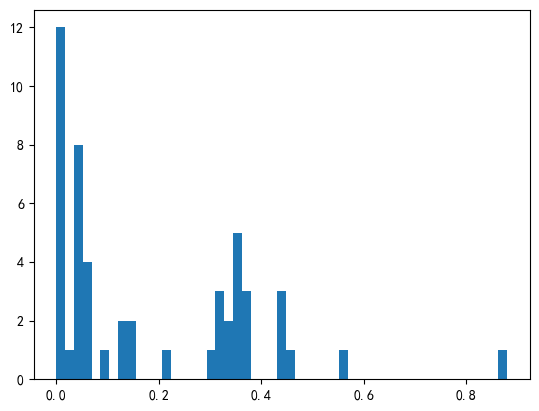

In [8]:
plt.hist(f,bins=f.count())
plt.show()

(array([12.,  1.,  8.,  4.,  0.,  1.,  0.,  2.,  2.,  0.,  0.,  0.,  1.,
         0.,  0.,  0.,  0.,  1.,  3.,  2.,  5.,  3.,  0.,  0.,  0.,  3.,
         1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([0.        , 0.01725145, 0.03450289, 0.05175434, 0.06900578,
        0.08625723, 0.10350868, 0.12076012, 0.13801157, 0.15526302,
        0.17251446, 0.18976591, 0.20701735, 0.2242688 , 0.24152025,
        0.25877169, 0.27602314, 0.29327458, 0.31052603, 0.32777748,
        0.34502892, 0.36228037, 0.37953182, 0.39678326, 0.41403471,
        0.43128615, 0.4485376 , 0.46578905, 0.48304049, 0.50029194,
        0.51754338, 0.53479483, 0.55204628, 0.56929772, 0.58654917,
        0.60380062, 0.62105206, 0.63830351, 0.65555495, 0.6728064 ,
        0.69005785, 0.70730929, 0.72456074, 0.74181218, 0.75906363,
        0.77631508, 0.79356652, 0.81081797, 0.82806942, 0.84532086,
        0.86257231, 0.87982375]

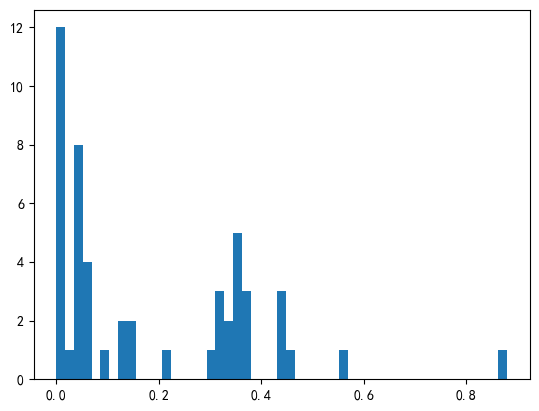

In [31]:
plt.hist(f,bins=f.count())
#plt.show()

(array([25.,  5.,  1., 10.,  6.,  2.,  1.,  0.,  0.,  1.]),
 array([0.        , 0.08798238, 0.17596475, 0.26394713, 0.3519295 ,
        0.43991188, 0.52789425, 0.61587663, 0.703859  , 0.79184138,
        0.87982375]),
 <BarContainer object of 10 artists>)

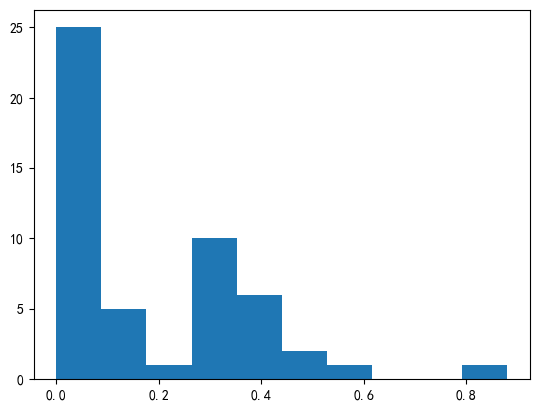

In [33]:
plt.hist(f,bins=10)
#plt.show()

C:\Users\86159\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

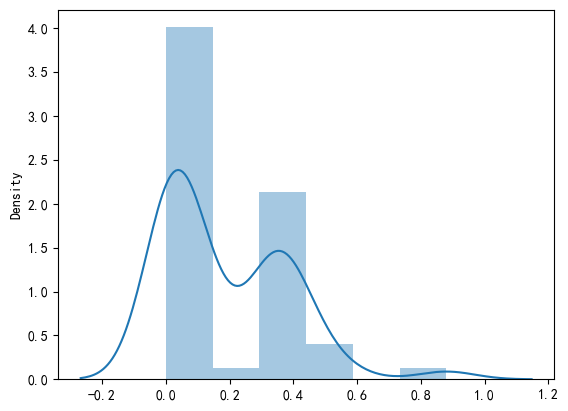

In [41]:
import seaborn as sns
sns.distplot(f,
            kde=True, # 线有无
            hist=True) # 直方图有无
#plt.show()

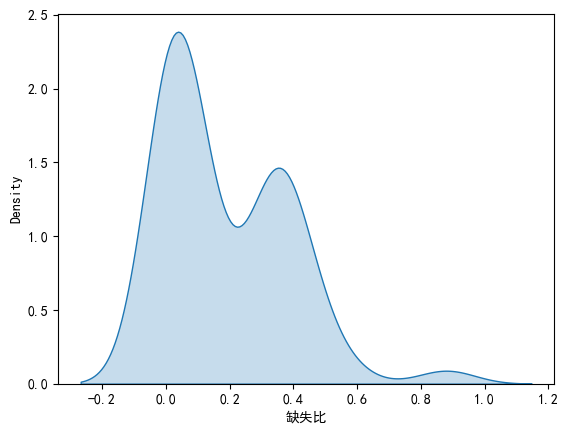

In [13]:
sns.kdeplot(f,shade=True) # https://zhuanlan.zhihu.com/p/409152814
plt.xlabel('缺失比')
plt.show()

<AxesSubplot:xlabel='缺失比', ylabel='Density'>

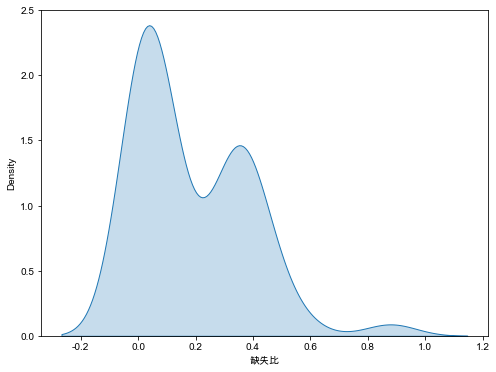

### 14 - 数据可视化

使用条形图可视化缺失值

In [15]:
c = pd.DataFrame((data.isnull().sum()/data.shape[0]).sort_values(ascending=True)).reset_index()
y = c.index
x = c[0]

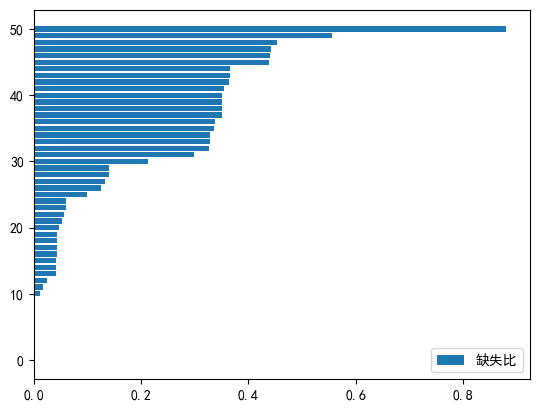

In [21]:
plt.barh(y,x,label='缺失比')
plt.legend(loc = 4) # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
plt.show()

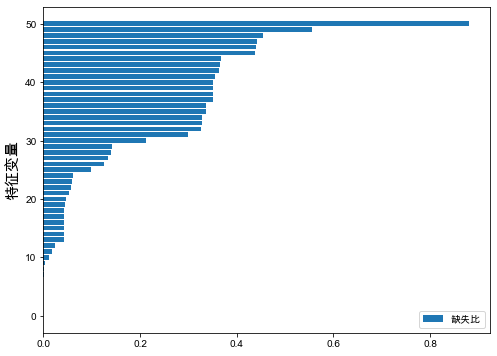

### 15 - 修改索引

将 null 的索引设置为 特征，列名为缺失比

In [44]:
pd.DataFrame(data.isnull().sum()/data.shape[0]).reset_index().rename(columns={'index':'特征',0:'缺失比'}).set_index('特征')

,缺失比
特征,
label,0.000000
sampleid,0.000000
d,0.000000
arrival,0.000000
iforderpv_24h,0.000000
decisionhabit_user,0.441332
historyvisit_7ordernum,0.879824
historyvisit_totalordernum,0.439774
hotelcr,0.001155


,缺失比
特征,
label,0.000000
sid,0.000000
iforderpv_24h,0.000000
h,0.000000
d,0.000000
sampleid,0.000000
arrival,0.000000
hotelcr,0.001155
hoteluv,0.001155


### 16 - 数据删除


**删除缺失比例为0.879824**的列

In [78]:
(data.isnull().sum()/data.shape[0]).sort_values(ascending=False)

historyvisit_7ordernum              0.879824
historyvisit_visit_detailpagenum    0.554698
firstorder_bu                       0.453590
decisionhabit_user                  0.441332
historyvisit_totalordernum          0.439774
historyvisit_avghotelnum            0.437816
delta_price1                        0.366405
delta_price2                        0.365529
customer_value_profit               0.363539
ctrip_profits                       0.354750
ordernum_oneyear                    0.350918
ordercanceledprecent                0.350918
ordercanncelednum                   0.350918
lasthtlordergap                     0.350918
avgprice                            0.337250
cr                                  0.336330
consuming_capacity                  0.327719
price_sensitive                     0.327719
starprefer                          0.326190
businessrate_pre                    0.298646
deltaprice_pre2_t1                  0.212720
lastpvgap                           0.140775
visitnum_o

In [77]:
(data.isnull().sum()/data.shape[0]).sort_values(ascending=False)==0.879824

historyvisit_7ordernum              False
historyvisit_visit_detailpagenum    False
firstorder_bu                       False
decisionhabit_user                  False
historyvisit_totalordernum          False
historyvisit_avghotelnum            False
delta_price1                        False
delta_price2                        False
customer_value_profit               False
ctrip_profits                       False
ordernum_oneyear                    False
ordercanceledprecent                False
ordercanncelednum                   False
lasthtlordergap                     False
avgprice                            False
cr                                  False
consuming_capacity                  False
price_sensitive                     False
starprefer                          False
businessrate_pre                    False
deltaprice_pre2_t1                  False
lastpvgap                           False
visitnum_oneyear                    False
commentnums_pre                   

尽管最大缺失率显示是 0.879824 ，但实际上的值并不是，无法通过缺失率筛选

In [80]:
data.isnull().sum().sort_values(ascending=False)

historyvisit_7ordernum              607030
historyvisit_visit_detailpagenum    382711
firstorder_bu                       312952
decisionhabit_user                  304495
historyvisit_totalordernum          303420
historyvisit_avghotelnum            302069
delta_price1                        252799
delta_price2                        252195
customer_value_profit               250822
ctrip_profits                       244758
ordernum_oneyear                    242114
ordercanceledprecent                242114
ordercanncelednum                   242114
lasthtlordergap                     242114
avgprice                            232684
cr                                  232049
consuming_capacity                  226108
price_sensitive                     226108
starprefer                          225053
businessrate_pre                    206049
deltaprice_pre2_t1                  146765
lastpvgap                            97127
visitnum_oneyear                     97035
commentnums

In [81]:
data.isnull().sum()==607030

label                               False
sampleid                            False
d                                   False
arrival                             False
iforderpv_24h                       False
decisionhabit_user                  False
historyvisit_7ordernum               True
historyvisit_totalordernum          False
hotelcr                             False
ordercanceledprecent                False
landhalfhours                       False
ordercanncelednum                   False
commentnums                         False
starprefer                          False
novoters                            False
consuming_capacity                  False
historyvisit_avghotelnum            False
cancelrate                          False
historyvisit_visit_detailpagenum    False
delta_price1                        False
price_sensitive                     False
hoteluv                             False
businessrate_pre                    False
ordernum_oneyear                  

In [84]:
data.loc[:,data.isnull().sum()!=607030]

,label,sampleid,d,arrival,iforderpv_24h,decisionhabit_user,historyvisit_totalordernum,hotelcr,ordercanceledprecent,landhalfhours,...,lowestprice_pre2,lasthtlordergap,businessrate_pre2,cityuvs,cityorders,lastpvgap,cr,sid,visitnum_oneyear,h
0,0,24636,2016-05-18,2016-05-18,0,NaN,NaN,1.04,NaN,22.0,...,615.0,NaN,0.29,12.880,3.147,NaN,NaN,7,NaN,12
1,1,24637,2016-05-18,2016-05-18,0,NaN,NaN,1.06,NaN,0.0,...,513.0,NaN,0.53,17.933,4.913,NaN,NaN,33,NaN,14
2,0,24641,2016-05-18,2016-05-19,0,NaN,NaN,1.05,NaN,3.0,...,382.0,NaN,0.60,3.993,0.760,NaN,NaN,10,NaN,19
3,0,24642,2016-05-18,2016-05-18,0,NaN,NaN,1.01,NaN,2.0,...,203.0,NaN,0.18,3.220,0.660,NaN,NaN,8,NaN,16
4,1,24644,2016-05-18,2016-05-19,0,NaN,NaN,1.00,NaN,0.0,...,84.0,NaN,NaN,0.013,NaN,NaN,NaN,1,NaN,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689940,1,2238419,2016-05-15,2016-05-17,1,19.0,NaN,1.06,NaN,1.0,...,406.0,NaN,0.48,13.573,1.660,1034.0,1.0,5,119.0,18
689941,1,2238421,2016-05-15,2016-05-15,1,10.0,3.0,1.06,0.33,49.0,...,199.0,713.0,0.51,2.880,0.513,179.0,2.0,15,1472.0,12
689942,0,2238422,2016-05-15,2016-05-17,0,NaN,NaN,1.07,NaN,0.0,...,544.0,NaN,0.45,15.293,2.067,0.0,NaN,8,107.0,0
689943,0,2238425,2016-05-15,2016-05-17,0,NaN,NaN,1.04,NaN,0.0,...,156.0,NaN,0.29,2.467,0.333,NaN,NaN,4,NaN,0


### 17 - 异常值处理

首先处理异常值，最低酒店定价有小于0的，有等于1的值，明显属于异常值。异常值处理方法较多，常见有直接删除，当缺失值处理等等

本例中，我们用盖帽法处理此异常值。

In [85]:
data.describe([0.01,0.25,0.5,0.75,0.99],include='all').T

,count,unique,top,freq,mean,std,min,1%,25%,50%,75%,99%,max
label,689945.0,NaN,NaN,NaN,0.274452,0.446238,0.0,0.0,0.0,0.0,1.0,1.0,1.0
sampleid,689945.0,NaN,NaN,NaN,628540.209625,414681.498697,24636.0,36205.88,312320.0,599637.0,887460.0,2226892.56,2238426.0
d,689945,7,2016-05-20,111985,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
arrival,689945,37,2016-05-20,110982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
iforderpv_24h,689945.0,NaN,NaN,NaN,0.193737,0.395226,0.0,0.0,0.0,0.0,0.0,1.0,1.0
decisionhabit_user,385450.0,NaN,NaN,NaN,5.317048,38.524483,0.0,1.0,2.0,3.0,5.0,27.0,3167.0
historyvisit_7ordernum,82915.0,NaN,NaN,NaN,1.856094,2.103862,1.0,1.0,1.0,1.0,2.0,7.0,106.0
historyvisit_totalordernum,386525.0,NaN,NaN,NaN,11.710487,17.251429,1.0,1.0,2.0,6.0,14.0,82.0,711.0
hotelcr,689148.0,NaN,NaN,NaN,1.060996,0.045264,1.0,1.0,1.03,1.05,1.09,1.19,3.18
ordercanceledprecent,447831.0,NaN,NaN,NaN,0.342119,0.35421,0.0,0.0,0.0,0.25,0.57,1.0,1.0


**定义盖帽法处理异常值**

In [86]:
data.loc[:,['lowestprice','lowestprice_pre']].describe([0.01,0.25,0.5,0.75,0.99],include='all').T

,count,mean,std,min,1%,25%,50%,75%,99%,max
lowestprice,687931.0,318.806242,575.782415,-3.0,37.0,116.0,200.0,380.0,1823.0,100000.0
lowestprice_pre,659689.0,315.954583,463.723643,1.0,38.0,118.0,208.0,385.0,1750.0,100000.0


In [24]:
col_01 = ['lowestprice','lowestprice_pre'] # 偏态严重

In [22]:
def block_lower(x):
# x是输⼊入的Series对象,替换1%分位数
    ql = x.quantile(.01) # 返回分位数，括号内填入的是分位数的百分比，如果括号内是0.5那么就是中位数，如果是0.25就是下四分位数
    out = x.mask(x<ql,ql) # https://vimsky.com/zh-tw/examples/usage/python-pandas-series-mask.html
    return(out)

def block_upper(x):
# x是输⼊入的Series对象,替换99%分位数
    qu = x.quantile(.99)
    out = x.mask(x>qu,qu)
    return(out)

In [25]:
data.loc[:,col_01]=data.loc[:,col_01].apply(block_upper)

data.loc[:,col_01]=data.loc[:,col_01].apply(block_lower)

In [26]:
data.loc[:,['lowestprice','lowestprice_pre']].describe([0.01,0.25,0.5,0.75,0.99],include='all').T

,count,mean,std,min,1%,25%,50%,75%,99%,max
lowestprice,687931.0,305.025771,297.382838,37.0,37.0,116.0,200.0,380.0,1823.0,1823.0
lowestprice_pre,659689.0,304.439507,287.192512,38.0,38.0,118.0,208.0,385.0,1750.0,1750.0


### 18 - 数据划分

In [27]:
data_copy = data.copy(deep=True) # 备份数据,deep=True是深拷贝，同浅拷贝有所不同，他不会因为备份数据改变而改变

In [29]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 689945 entries, 0 to 689944
Data columns (total 51 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   label                             689945 non-null  int64  
 1   sampleid                          689945 non-null  int64  
 2   d                                 689945 non-null  object 
 3   arrival                           689945 non-null  object 
 4   iforderpv_24h                     689945 non-null  int64  
 5   decisionhabit_user                385450 non-null  float64
 6   historyvisit_7ordernum            82915 non-null   float64
 7   historyvisit_totalordernum        386525 non-null  float64
 8   hotelcr                           689148 non-null  float64
 9   ordercanceledprecent              447831 non-null  float64
 10  landhalfhours                     661312 non-null  float64
 11  ordercanncelednum                 447831 non-null  f

运用切片选取数据

In [28]:
X = data_copy.iloc[:,2:]
y = data_copy.label

In [30]:
# test_size为测试集所占比例，random_state为随机种子，用于锁定随机数
Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,y,test_size=0.3,random_state=666)

### 19 - 特征筛选

将不同类型的变量进行区别对待处理

In [31]:
cols = X.columns.to_list()
col_no = ['sid','iforderpv_24h','h'] #没有缺失值的特征
col_clf = ['decisionhabit_user'] # 分类型变量
col_neg = ['delta_price1','delta_price2','customer_value_profit'
           ,'ctrip_profits','deltaprice_pre2_t1'] # 含有负数
col_35 = ['firstorder_bu','decisionhabit_user','historyvisit_totalordernum'
 ,'historyvisit_avghotelnum','customer_value_profit','ctrip_profits','ordernum_oneyear'
 ,'lasthtlordergap','ordercanceledprecent','ordercanncelednum'] # 缺失35% —— 55%

筛选方差大于100的列

In [32]:
data.columns[data.describe(include='all').T['std'] >100]

Index(['sampleid', 'ordercanncelednum', 'commentnums', 'novoters',
       'cancelrate', 'delta_price1', 'hoteluv', 'avgprice', 'lowestprice',
       'delta_price2', 'commentnums_pre', 'commentnums_pre2', 'novoters_pre2',
       'novoters_pre', 'lowestprice_pre', 'uv_pre', 'uv_pre2',
       'lowestprice_pre2', 'lasthtlordergap', 'lastpvgap', 'sid',
       'visitnum_oneyear'],
      dtype='object')

In [33]:
col_std = data.columns[data.describe(include='all').T['std'] >100].to_list() # std >100

In [34]:
col_norm = list(set(cols)-set(col_clf + col_std + col_neg + col_no +col_35))

In [35]:
col_norm

['consuming_capacity',
 'customereval_pre2',
 'cityorders',
 'starprefer',
 'historyvisit_7ordernum',
 'arrival',
 'businessrate_pre2',
 'cancelrate_pre',
 'cr',
 'cr_pre',
 'hotelcr',
 'historyvisit_visit_detailpagenum',
 'cityuvs',
 'landhalfhours',
 'd',
 'businessrate_pre',
 'price_sensitive']

通过remove删除列

In [36]:
col_std.remove('delta_price1')
col_std.remove('delta_price2')
col_std.remove('sampleid')
col_std.remove('lasthtlordergap')

### 20 - 缺失值填补

- 分类型变量用 '众数填补' —— col_clf
- 含有负数的特征用 '中值填补' —— col_neg
- std > 100 方差大于100的连续型变量用 '中值填补' —— col_std
- 缺失35%——55%用 '常数 -1 填充' 单独做一类
- 其余变量用 '均值填补' —— col_norm

In [37]:
Xtrain.loc[:,col_clf] = Xtrain.loc[:,col_clf].fillna(Xtrain.loc[:,col_clf].mode()) # 众数

In [38]:
Xtrain.loc[:,col_neg] = Xtrain.loc[:,col_neg].fillna(Xtrain.loc[:,col_neg].median()) # 中位数

In [39]:
Xtrain.loc[:,col_std] = Xtrain.loc[:,col_std].fillna(Xtrain.loc[:,col_std].median())

In [40]:
Xtrain.loc[:,col_norm] = Xtrain.loc[:,col_norm].fillna(Xtrain.loc[:,col_norm].mean())

C:\Users\86159\AppData\Local\Temp\ipykernel_4904\1303577457.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  Xtrain.loc[:,col_norm] = Xtrain.loc[:,col_norm].fillna(Xtrain.loc[:,col_norm].mean())


In [41]:
Xtrain.loc[:,col_35] = Xtrain.loc[:,col_35].fillna(-1)

**检查缺失值填补情况**

查看训练集合的缺失值情况

In [42]:
Xtrain.isna().any().sum()

0

查看数据集合的缺失情况

In [43]:
Xtest.isna().any().sum()

44

In [42]:
# 特征创造
# ordernum_oneyear_train = Xtrain.loc[:,'ordernum_oneyear'].reset_index(drop=True)
# ordernum_oneyear_test = Xtest.loc[:,'ordernum_oneyear'].reset_index(drop=True)
# avgprice_train = Xtrain.loc[:,'avgprice'].reset_index(drop=True)
# avgprice_test = Xtest.loc[:,'avgprice'].reset_index(drop=True)

# M_train = ordernum_oneyear_train * avgprice_train

# M_test = ordernum_oneyear_test * avgprice_test

# M_train.to_csv('M_train.csv')
# M_test.to_csv('M_test.csv')

## 特征选择

查看正负样本均衡与否

In [44]:
y.value_counts()

0    500588
1    189357
Name: label, dtype: int64

### 方差过滤

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html

删除日期列

In [45]:
Xtrain = Xtrain.drop(columns=['d', 'arrival'])
Xtest = Xtest.drop(columns=['d', 'arrival'])

方差过滤

In [52]:
selector = VarianceThreshold()
Xtrain_var0 = selector.fit(Xtrain).transform(Xtrain) # 删除 0 方差后的新数组

In [46]:
VarianceThreshold().fit(Xtrain)

VarianceThreshold()

In [49]:
VarianceThreshold().fit(Xtrain).transform(Xtrain) # 等同于 VarianceThreshold().fit_transform(Xtrain)

array([[ 1.00000000e+00,  6.00000000e+00,  1.00000000e+00, ...,
         1.11000000e+02,  2.16200000e+03,  1.80000000e+01],
       [ 0.00000000e+00,  2.00000000e+00,  1.85898497e+00, ...,
         5.40000000e+01,  1.39700000e+03,  2.20000000e+01],
       [ 0.00000000e+00,  1.00000000e+00,  1.00000000e+00, ...,
         3.85000000e+02,  2.88100000e+03,  1.50000000e+01],
       ...,
       [ 1.00000000e+00, -1.00000000e+00,  1.85898497e+00, ...,
         6.00000000e+00,  1.77200000e+03,  3.00000000e+00],
       [ 0.00000000e+00, -1.00000000e+00,  1.00000000e+00, ...,
         6.55000000e+02,  1.31600000e+03,  2.10000000e+01],
       [ 0.00000000e+00, -1.00000000e+00,  1.85898497e+00, ...,
         8.00000000e+00,  1.31600000e+03,  2.30000000e+01]])

In [48]:
VarianceThreshold().fit(Xtrain).transform(Xtrain).shape

(482961, 47)

In [50]:
Xtrain.shape

(482961, 47)

过滤完后查看数据形状

In [123]:
Xtrain.shape

(482961, 47)

In [124]:
Xtrain_var0.shape

(482961, 47)

### F_检验

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html

http://lijiancheng0614.github.io/scikit-learn/modules/generated/sklearn.feature_selection.f_classif.html

In [53]:
F , pvalues_f = f_classif(Xtrain,Ytrain)

查看F值

In [55]:
F

array([5.91193624e+03, 1.93995904e+00, 5.66187178e+02, 1.10748523e+04,
       6.52588756e+03, 5.72616656e+03, 2.34402404e+02, 4.71035154e+03,
       9.63228309e-01, 3.48993536e+01, 2.69161646e+00, 2.96230367e+02,
       4.45001376e+00, 4.09092508e+01, 1.84634401e-01, 6.66912134e+02,
       4.02901071e+00, 1.31726129e+03, 6.45113345e+03, 1.24045963e+04,
       6.35625789e+03, 1.11075725e+02, 2.11018777e+03, 9.11616695e+02,
       3.76655886e+02, 9.85304381e+02, 8.61980927e+00, 2.95985745e+03,
       3.59246695e+01, 1.79738069e+02, 7.67313405e+00, 3.04910588e-02,
       2.70403338e+03, 1.18798987e+01, 1.52209921e+03, 1.52800082e+03,
       1.97523458e+03, 1.67256060e+03, 4.20295879e+02, 8.55081976e+03,
       4.81856327e+03, 4.54167636e+03, 6.54280347e+01, 1.58147894e+04,
       6.31860633e+01, 3.35011334e+02, 2.98914773e+03])

In [54]:
F.shape

(47,)

查看p值

In [56]:
pvalues_f # 其中的数越大，相关性越低

array([0.00000000e+000, 1.63673622e-001, 4.47689829e-125, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 6.72579265e-053, 0.00000000e+000,
       3.26375337e-001, 3.47427483e-009, 1.00878081e-001, 2.28516134e-066,
       3.49014787e-002, 1.59609407e-010, 6.67420584e-001, 5.90640741e-147,
       4.47247156e-002, 4.92139290e-288, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 5.73245469e-026, 0.00000000e+000, 4.50308055e-200,
       7.16278251e-084, 4.64497778e-216, 3.32542335e-003, 0.00000000e+000,
       2.05240027e-009, 5.62279399e-041, 5.60511624e-003, 8.61380748e-001,
       0.00000000e+000, 5.67478538e-004, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 2.30633608e-093, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 6.04130835e-016, 0.00000000e+000,
       1.88475684e-015, 8.25479550e-075, 0.00000000e+000])

In [57]:
pvalues_f.shape

(47,)

**与标签没有显著相关性的变量有7个**

In [58]:
(pvalues_f>0.01).sum()

7

**剔除没有相关性的变量**

In [59]:
col_f = list(Xtrain.columns[pvalues_f<0.01])
col_f

['iforderpv_24h',
 'historyvisit_7ordernum',
 'historyvisit_totalordernum',
 'hotelcr',
 'ordercanceledprecent',
 'landhalfhours',
 'ordercanncelednum',
 'starprefer',
 'consuming_capacity',
 'cancelrate',
 'delta_price1',
 'hoteluv',
 'businessrate_pre',
 'ordernum_oneyear',
 'cr_pre',
 'avgprice',
 'lowestprice',
 'firstorder_bu',
 'customereval_pre2',
 'delta_price2',
 'commentnums_pre',
 'customer_value_profit',
 'commentnums_pre2',
 'cancelrate_pre',
 'novoters_pre2',
 'ctrip_profits',
 'deltaprice_pre2_t1',
 'lowestprice_pre',
 'uv_pre',
 'uv_pre2',
 'lowestprice_pre2',
 'lasthtlordergap',
 'businessrate_pre2',
 'cityuvs',
 'cityorders',
 'lastpvgap',
 'cr',
 'sid',
 'visitnum_oneyear',
 'h']

In [60]:
Xtrain = Xtrain.loc[:,col_f] # 通过切片筛选所需要的数据
Xtest = Xtest.loc[:,col_f]

重置索引

In [64]:
Xtrain.index = range(Xtrain.shape[0]) # 重置索引
Ytrain = Ytrain.reset_index(drop=True) # 重置索引且删除下来的索引列
Xtest.index = range(Xtest.shape[0]) # 重置索引

Ytest = Ytest.reset_index(drop=True)

In [108]:
Xtrain

,iforderpv_24h,historyvisit_7ordernum,historyvisit_totalordernum,hotelcr,ordercanceledprecent,landhalfhours,ordercanncelednum,starprefer,consuming_capacity,cancelrate,...,lowestprice_pre2,lasthtlordergap,businessrate_pre2,cityuvs,cityorders,lastpvgap,cr,sid,visitnum_oneyear,h
0,1,1.000000,6.0,1.04,0.84,9.0,16.0,90.000000,44.000000,1076.0,...,338.0,713.0,0.55000,5.387,0.680000,312.0,1.140000,111,2162.0,18
1,0,1.858985,25.0,1.05,0.99,0.0,374.0,63.300000,24.000000,744.0,...,728.0,97890.0,0.36838,3.853,0.027000,3594.0,1.000000,54,1397.0,22
2,0,1.000000,5.0,1.01,0.00,24.0,0.0,84.000000,84.000000,149.0,...,562.0,4601.0,0.02000,11.573,0.813000,299.0,1.070000,385,2881.0,15
3,1,1.858985,-1.0,1.11,-1.00,3.0,2.0,67.543379,39.176679,543.0,...,149.0,-1.0,0.18000,10.567,3.033000,1273.0,1.000000,37,1218.0,15
4,1,1.858985,1.0,1.06,0.00,0.0,0.0,40.000000,13.000000,276.0,...,99.0,52076.0,0.36838,0.160,0.013000,31216.0,2.000000,61,318.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482956,0,1.000000,2.0,1.06,0.50,0.0,1.0,80.000000,19.000000,439.0,...,333.0,1947.0,0.71000,8.080,2.047000,1852.0,1.500000,6,289.0,12
482957,1,1.858985,1.0,1.01,1.00,24.0,1.0,84.000000,100.000000,171.0,...,1283.0,484891.0,0.04000,0.287,0.013000,5922.0,1.137801,246,558.0,23
482958,1,1.858985,-1.0,1.07,-1.00,0.0,2.0,67.543379,39.176679,1282.0,...,548.0,-1.0,0.52000,1.440,0.113000,2033.0,1.137801,6,1772.0,3
482959,0,1.000000,-1.0,1.01,-1.00,0.0,2.0,40.000000,29.000000,42.0,...,179.0,-1.0,0.01000,0.467,2.250719,2838.0,1.137801,655,1316.0,21


In [109]:
Ytrain

0         0
1         0
2         0
3         0
4         0
         ..
482956    0
482957    1
482958    0
482959    0
482960    0
Name: label, Length: 482961, dtype: int64

### 嵌入法筛选特征

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html

https://cloud.tencent.com/developer/article/1770568

In [65]:
# 初步探索
RFC_clf = RFC(n_estimators=10,random_state=0)
X_embedded = SelectFromModel(RFC_clf,threshold=0.05).fit_transform(Xtrain,Ytrain)

C:\Users\86159\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\feature_selection\_base.py:96: UserWarning: No features were selected: either the data is too noisy or the selection test too strict.
  warnings.warn(


没有选择任何特征：要么是数据的噪声太大，要么是选择测试太严格。

In [66]:
RFC_clf # RandomForestClassifier：随机森林分类器

RandomForestClassifier(n_estimators=10, random_state=0)

In [68]:
SelectFromModel(RFC_clf,threshold=0.05) # estimator：估计器；SelectFromModel：从模型中选择

SelectFromModel(estimator=RandomForestClassifier(n_estimators=10,
                                                 random_state=0),
                threshold=0.05)

In [67]:
X_embedded

array([], shape=(482961, 0), dtype=float64)

In [70]:
Xtrain.shape

(482961, 40)

**利用随机森林调出特征重要性**

In [76]:
importance = RFC_clf.fit(Xtrain,Ytrain).feature_importances_

In [71]:
RFC_clf.fit(Xtrain,Ytrain)

RandomForestClassifier(n_estimators=10, random_state=0)

In [77]:
importance

array([0.01156298, 0.01124423, 0.01603135, 0.01696446, 0.01757582,
       0.01610963, 0.01827279, 0.02068493, 0.0208077 , 0.01977797,
       0.01781692, 0.0205374 , 0.02145331, 0.01889979, 0.0215288 ,
       0.02311268, 0.0211745 , 0.01059171, 0.02257649, 0.01982048,
       0.02586689, 0.02613122, 0.02517602, 0.0253274 , 0.02548618,
       0.02867502, 0.02452528, 0.0271405 , 0.02818511, 0.0280574 ,
       0.02785365, 0.02970648, 0.0324781 , 0.04181169, 0.03812163,
       0.03831572, 0.04338588, 0.03902758, 0.04048731, 0.03769701])

In [79]:
importance.max()

0.04338587876711012

同样，结束后查看下数据的形状

In [73]:
Xtrain.shape

(482961, 40)

In [74]:
Ytrain.shape

(482961,)

**嵌入法画学习曲线**

利用随机森林特征重要性属性feature_importances_定义阈值范围，以嵌入选择模型SelectFromModel为基础，通过交叉验证cross_val_score得到每个阈值下模型得分情况。

https://scikit-learn.org.cn/view/663.html

27:38:071590


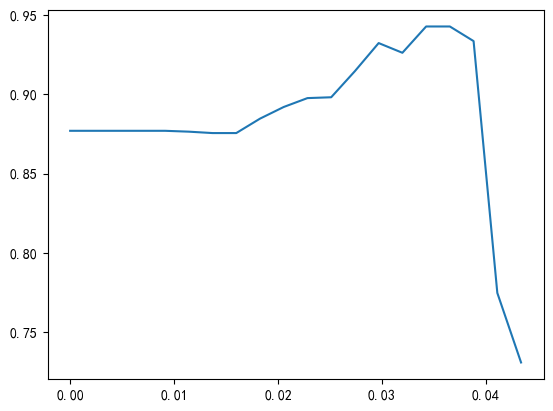

In [78]:
importance = RFC_clf.fit(Xtrain,Ytrain).feature_importances_
threshold = np.linspace(0,importance.max(),20) # https://numpy.org/doc/stable/reference/generated/numpy.linspace.html
score = []
time0 = time()
for i in threshold:
    X_embedded = SelectFromModel(RFC_clf,threshold=i).fit_transform(Xtrain,Ytrain) # 特征筛选后的数据集
    val = cross_val_score(RFC_clf,X_embedded,Ytrain,cv=5).mean() # https://scikit-learn.org.cn/view/663.html ,评分（通过交叉验证评估准确率）
    score.append(val)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
plt.plot(threshold,score)
plt.show()

In [80]:
threshold

array([0.        , 0.00228347, 0.00456693, 0.0068504 , 0.00913387,
       0.01141734, 0.0137008 , 0.01598427, 0.01826774, 0.02055121,
       0.02283467, 0.02511814, 0.02740161, 0.02968507, 0.03196854,
       0.03425201, 0.03653548, 0.03881894, 0.04110241, 0.04338588])

In [83]:
score

[0.8769714352476192,
 0.8769714352476192,
 0.8769714352476192,
 0.8769714352476192,
 0.8769714352476192,
 0.8764268755773748,
 0.8755427471087543,
 0.8755427471087543,
 0.8846407932403071,
 0.891997490002867,
 0.8975962837242353,
 0.8981263486045261,
 0.9146183608085018,
 0.9323071655407743,
 0.9261824457966024,
 0.942771776306282,
 0.942771776306282,
 0.9335536403715878,
 0.7747188711705298,
 0.7308478339724491]

In [82]:
np.max(score) #最高分

0.942771776306282

最高分对应的重要性阈值

In [84]:
threshold[np.argmax(score)]

0.034252009552981674

In [91]:
X_embedded = SelectFromModel(RFC_clf,threshold=0.031000416340192495).fit_transform(Xtrain,Ytrain) # 用最高分前一个 threshold 筛选

In [92]:
X_embedded.shape

(482961, 8)

In [93]:
X_embedded

array([[5.50000000e-01, 5.38700000e+00, 6.80000000e-01, ...,
        1.11000000e+02, 2.16200000e+03, 1.80000000e+01],
       [3.68380423e-01, 3.85300000e+00, 2.70000000e-02, ...,
        5.40000000e+01, 1.39700000e+03, 2.20000000e+01],
       [2.00000000e-02, 1.15730000e+01, 8.13000000e-01, ...,
        3.85000000e+02, 2.88100000e+03, 1.50000000e+01],
       ...,
       [5.20000000e-01, 1.44000000e+00, 1.13000000e-01, ...,
        6.00000000e+00, 1.77200000e+03, 3.00000000e+00],
       [1.00000000e-02, 4.67000000e-01, 2.25071866e+00, ...,
        6.55000000e+02, 1.31600000e+03, 2.10000000e+01],
       [5.90000000e-01, 8.70700000e+00, 1.52000000e+00, ...,
        8.00000000e+00, 1.31600000e+03, 2.30000000e+01]])

In [94]:
RFC_clf.feature_importances_ # 前面的 importance

array([0.01156298, 0.01124423, 0.01603135, 0.01696446, 0.01757582,
       0.01610963, 0.01827279, 0.02068493, 0.0208077 , 0.01977797,
       0.01781692, 0.0205374 , 0.02145331, 0.01889979, 0.0215288 ,
       0.02311268, 0.0211745 , 0.01059171, 0.02257649, 0.01982048,
       0.02586689, 0.02613122, 0.02517602, 0.0253274 , 0.02548618,
       0.02867502, 0.02452528, 0.0271405 , 0.02818511, 0.0280574 ,
       0.02785365, 0.02970648, 0.0324781 , 0.04181169, 0.03812163,
       0.03831572, 0.04338588, 0.03902758, 0.04048731, 0.03769701])

In [95]:
RFC_clf.feature_importances_>0.031000416340192495

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True])

In [96]:
col_k = list(Xtrain.columns[RFC_clf.feature_importances_>0.031000416340192495])

In [97]:
col_k

['businessrate_pre2',
 'cityuvs',
 'cityorders',
 'lastpvgap',
 'cr',
 'sid',
 'visitnum_oneyear',
 'h']

**利用阈值选择出 8 个特征**

In [99]:
col_k_ = ['lasthtlordergap',
 'cityorders',
 'lastpvgap',
 'cr',
 'sid',
 'visitnum_oneyear',
 'h'] # 不需要，后面会把对应的特征删除

将数组转行为DataFrame数据框

In [98]:
Xtrain_new = pd.DataFrame(X_embedded,columns = col_k )
Xtrain_new.head()

,businessrate_pre2,cityuvs,cityorders,lastpvgap,cr,sid,visitnum_oneyear,h
0,0.55000,5.387,0.680,312.0,1.14,111.0,2162.0,18.0
1,0.36838,3.853,0.027,3594.0,1.00,54.0,1397.0,22.0
2,0.02000,11.573,0.813,299.0,1.07,385.0,2881.0,15.0
3,0.18000,10.567,3.033,1273.0,1.00,37.0,1218.0,15.0
4,0.36838,0.160,0.013,31216.0,2.00,61.0,318.0,5.0


通过切片索引需要的列，重置索引，并查看前5行

In [100]:
Xtest_new = Xtest.loc[:,col_k].reset_index(drop=True).head()

查看每个列之间的相关性

**过滤高度相关的特征**
热图用于特征间的相关性分析，通过绘制热图，分析发现有以下两个高度相关的变量，最终删除特征cityuvs。

In [102]:
Xtrain_new.corr() # 特征间相关度

,businessrate_pre2,cityuvs,cityorders,lastpvgap,cr,sid,visitnum_oneyear,h
businessrate_pre2,1.000000,0.188272,0.204793,0.009093,0.109480,3.429538e-02,0.005294,1.842357e-02
cityuvs,0.188272,1.000000,0.977572,0.013895,0.052071,4.212451e-03,-0.004696,-3.797742e-02
cityorders,0.204793,0.977572,1.000000,0.013008,0.055380,4.582303e-03,-0.003560,-4.065868e-02
lastpvgap,0.009093,0.013895,0.013008,1.000000,0.005228,-9.018651e-02,-0.016246,1.805242e-02
cr,0.109480,0.052071,0.055380,0.005228,1.000000,2.981629e-03,0.000437,7.141979e-04
sid,0.034295,0.004212,0.004582,-0.090187,0.002982,1.000000e+00,-0.027661,-3.709865e-07
visitnum_oneyear,0.005294,-0.004696,-0.003560,-0.016246,0.000437,-2.766054e-02,1.000000,-1.230602e-02
h,0.018424,-0.037977,-0.040659,0.018052,0.000714,-3.709865e-07,-0.012306,1.000000e+00


<AxesSubplot:>

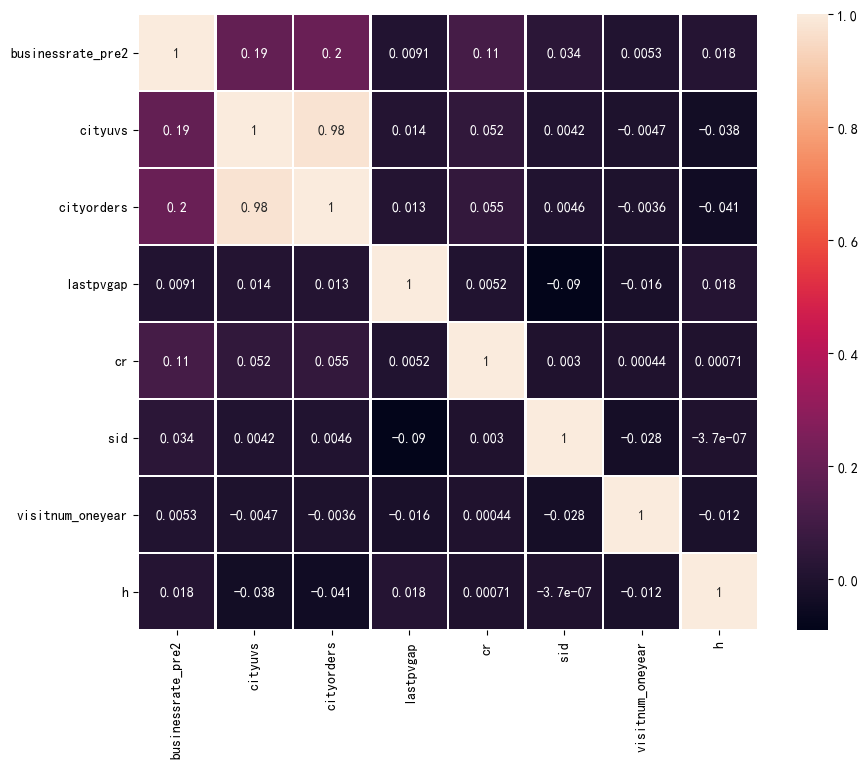

In [101]:
plt.figure(figsize=(10,8))
sns.heatmap(Xtrain_new.corr(),annot=True,linewidths=1)

发现cityorders 与 cityuvs 高度相关，删除其中一个列

In [104]:
Xtrain_new

,businessrate_pre2,cityorders,lastpvgap,cr,sid,visitnum_oneyear,h
0,0.55000,0.680000,312.0,1.140000,111.0,2162.0,18.0
1,0.36838,0.027000,3594.0,1.000000,54.0,1397.0,22.0
2,0.02000,0.813000,299.0,1.070000,385.0,2881.0,15.0
3,0.18000,3.033000,1273.0,1.000000,37.0,1218.0,15.0
4,0.36838,0.013000,31216.0,2.000000,61.0,318.0,5.0
...,...,...,...,...,...,...,...
482956,0.71000,2.047000,1852.0,1.500000,6.0,289.0,12.0
482957,0.04000,0.013000,5922.0,1.137801,246.0,558.0,23.0
482958,0.52000,0.113000,2033.0,1.137801,6.0,1772.0,3.0
482959,0.01000,2.250719,2838.0,1.137801,655.0,1316.0,21.0


In [ ]:
Xtrain_new.drop(columns='cityuvs',axis=1,inplace=True)
Xtest_new.drop(columns='cityuvs',axis=1,inplace=True)

**保存清洗后的数据**

In [105]:
Xtrain_new.to_csv('Xtrain_new.csv')
Xtest_new.to_csv('Xtest_new.csv')
Ytrain.to_csv('Ytrain.csv')
Ytest.to_csv('Ytest.csv')

## 建模与调参

### 弱评估器选择

24:09:043768
0.7254229637542698 0


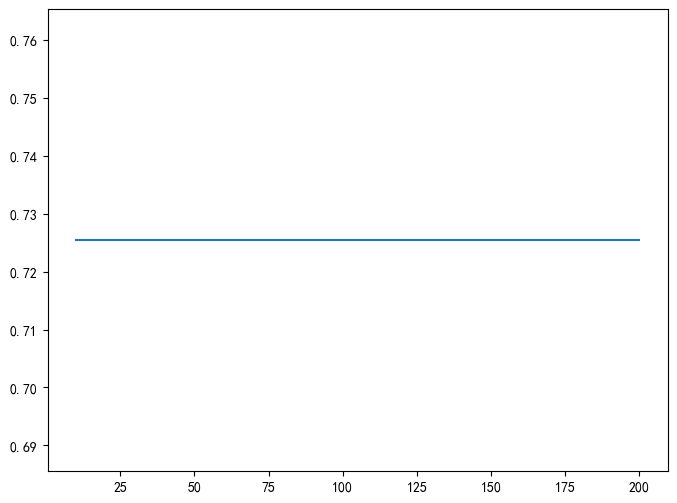

In [107]:
score = []
time0 = time()
for i in range(10,201,10):
    rfc = RFC(n_estimators= i
             ,max_depth=3
             ,random_state=0)
    score_ = cross_val_score(rfc,Xtrain_new,Ytrain,cv=5).mean()
    score.append(score_)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
print(max(score),np.argmax(score)) # 返回沿轴的最大值的索引（后一个输出）
plt.figure(figsize=(8,6))
plt.plot(range(10,201,10),score)
plt.show()

### 最大深度选择

05:41:132984
得分： 0.8939818849773287 最大深度： 20


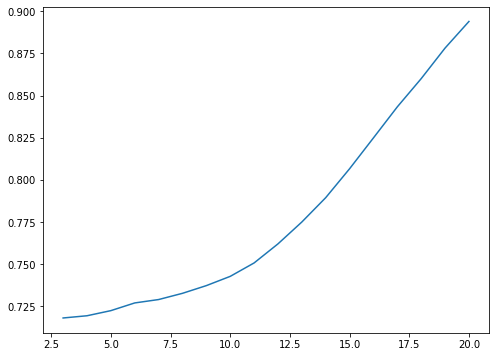

In [79]:
score = []
time0 = time()
for i in np.arange(3, 21, 1):
    rfc = RFC(n_estimators= 10
             ,max_depth= i
             ,random_state=0)
    score_ = cross_val_score(rfc,Xtrain_new,Ytrain,cv=5).mean()
    score.append(score_)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
print('得分：',max(score),'最大深度：',np.arange(3, 21, 1)[np.argmax(score)])
plt.figure(figsize=(8,6))
plt.plot(np.arange(3, 21, 1),score)
plt.show()

### 最小分割样本数选择

08:21:638368
得分： 0.8066083426188453 最小分支数： 2


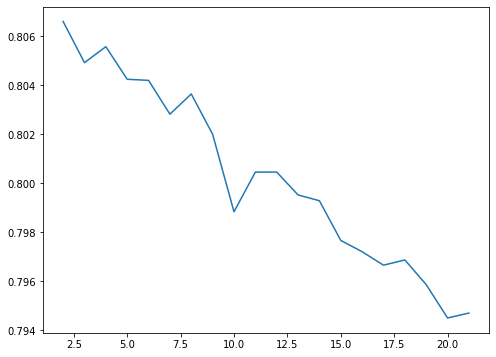

In [80]:
score_2 = []
time0 = time()
for i in np.arange(2, 22, 1):
    rfc = RFC(n_estimators= 10
             ,max_depth= 15
             ,min_samples_split= i
             ,random_state=0)
    score_ = cross_val_score(rfc,Xtrain_new,Ytrain,cv=5).mean()
    score_2.append(score_)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
print('得分：',max(score_2),'最小分支数：',np.arange(2, 22, 1)[np.argmax(score_2)])
plt.figure(figsize=(8,6))
plt.plot(np.arange(2, 22, 1),score_2)
plt.show()

### 最小叶子结点样本数选择

04:14:709608
得分： 0.8066083426188453 最小叶子数： 1


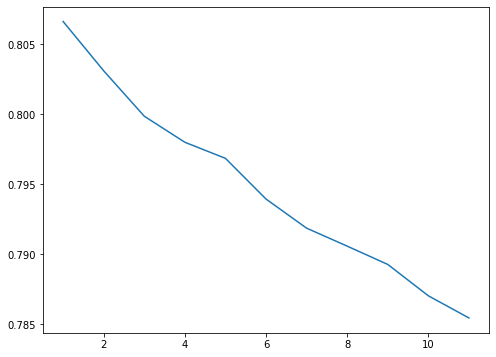

In [81]:
score_3 = []
time0 = time()
for i in np.arange(1, 12, 1):
    rfc = RFC(n_estimators= 10
             ,max_depth= 15
             ,min_samples_split= 2
             ,min_samples_leaf = i
             ,random_state=0)
    score_ = cross_val_score(rfc,Xtrain_new,Ytrain,cv=5).mean()
    score_3.append(score_)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%M:%S:%f"))
print('得分：',max(score_3),'最小叶子数：',np.arange(1, 12, 1)[np.argmax(score_3)])
plt.figure(figsize=(8,6))
plt.plot(np.arange(1, 12, 1),score_3)
plt.show()

### 最小评估器再次选择

31:49:492826
0.9043809229615084 最佳分类器数： 180


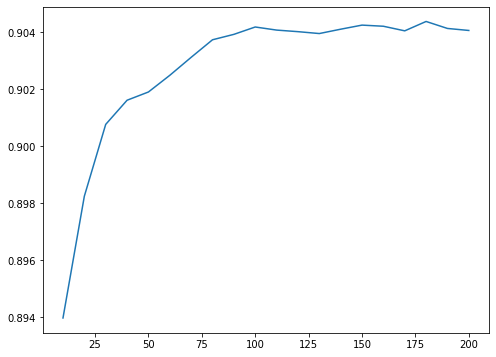

In [102]:
score_4 = []
time0 = time()
for i in range(10,201,10):
    rfc = RFC(n_estimators= i
             ,max_depth=20
             ,random_state=0)
    score_ = cross_val_score(rfc,Xtrain_new,Ytrain,cv=5).mean()
    score_4.append(score_)
print(datetime.datetime.fromtimestamp(time()-time0).strftime("%H:%M:%S"))
print(max(score_4),'最佳分类器数：',range(10,201,10)[np.argmax(score_4)])
plt.figure(figsize=(8,6))
plt.plot(range(10,201,10),score_4)
plt.show()
# 运行1个半小时

### 确定参数

In [106]:
clf = RFC(n_estimators=180
         ,max_depth=15
         ,min_samples_leaf=1
         ,min_samples_split=2
         ,random_state=0
         )
clf = clf.fit(Xtrain_new,Ytrain)

查看训练集和测试集的分数

In [107]:
clf.score(Xtrain_new,Ytrain)

0.8311662235362908

In [108]:
clf.score(Xtest_new,Ytest)

0.8119391458799907

In [109]:
clf = RFC(n_estimators=180
         ,max_depth=20
         ,min_samples_leaf=1
         ,min_samples_split=2
         ,random_state=0
         )
clf = clf.fit(Xtrain_new,Ytrain)

In [110]:
clf.score(Xtrain_new,Ytrain)

0.9425305870282317

In [111]:
clf.score(Xtest_new,Ytest)

0.9049398923983833

另一种方法使用网格搜素，但不建议使用，耗时特别长

In [ ]:
# from sklearn.model_selection import GridSearchCV 
# time0 = time()
# rfc = RFC(n_estimators= 10
#           ,random_state=0)
# GS = GridSearchCV(rfc,param_grid,cv=5)
# GS.fit(Xtrain_new,ytrain)
# print('最佳参数：',GS.best_params_)
# print('最高得分：',GS.best_score_)
# print(datetime.datetime.fromtimestamp(time()-time0).strftime("%H:%M:%S"))

查看特征重要性

In [112]:
clf.feature_importances_

array([0.12778966, 0.13655849, 0.12457015, 0.13714743, 0.10208397,
       0.13347588, 0.14272563, 0.09564879])

定义函数绘制AUC曲线

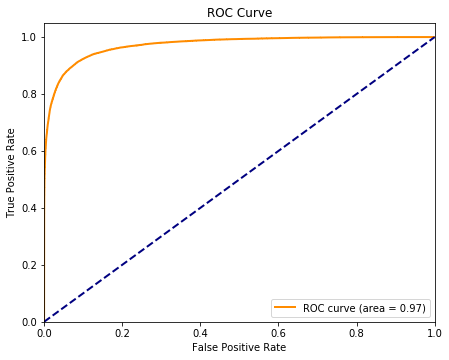

In [116]:
model = RFC(n_estimators=180
         ,max_depth=20
         ,min_samples_leaf=1
         ,min_samples_split=2
         ,random_state=0
         )
# ROC
y_score = model.fit(Xtrain_new, Ytrain).predict_proba(Xtest_new)  # 随机森林
fpr, tpr, thresholds = roc_curve(Ytest, y_score[:, 1])
roc_auc = auc(fpr, tpr)
def drawRoc(roc_auc,fpr,tpr):
    plt.subplots(figsize=(7, 5.5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
drawRoc(roc_auc, fpr, tpr)